# import

In [1]:
import numpy as np
import dimod
import dwave_networkx as dnx
import networkx as nx
import minorminer
import minorminer.layout as mml
%matplotlib inline
import dwave.inspector
import math
from datetime import datetime
from pathlib import Path  
import pandas as pd
import os

from matplotlib.pyplot import subplots
from matplotlib.table import Table
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools  



def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

In [2]:

from dwave.system import DWaveSampler

# Use a D-Wave system as the sampler
f = open("../token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage2_prototype1.1 was selected.


# Tiling patterns

How to tile the different $J_{\Box}$? The challenge then becomes to stich the (even) or (odd) parity encoding next to the other one. For that purpose, a square lattice is divided as a checkerboard lattice with A and B square cells (A and B refer to the S sublattice). Within each of these cells, a P=+1 or -1 cell can sit. We need that cells of (P,S) = (1,A) be compatible with (1, B) and (-1, B), and (-1,A) needs to be compatible with (1,B) and (-1, B). Importantly, (1,S) does not need to be compatible with (-1, S). 

#### Plot a given checkerboard pattern:

This cell is a practice plot for a grid with qubit values on the edges. 

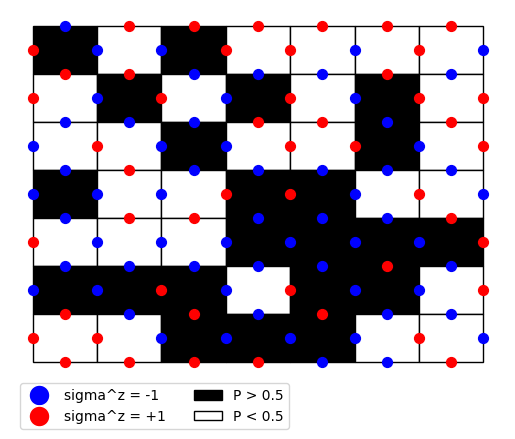

In [3]:
Lx = 7; Ly = 7;
#this is the plaquette values
ary = np.random.rand(Lx,Ly)
#random_colors = np.random.randint(0, 2, (Lx, Ly))
#this is the individual qubit values (at nodes)
node_values = np.random.randint(0, 2, (Lx+1, Ly+1))

ybond_qubit = np.random.randint(0, 2, (Lx, Ly+1))
xbond_qubit = np.random.randint(0, 2, (Lx+1, Ly))

cell_colors=("white", "black")
font_colors=("black", "white")
node_colors = ("red", "blue")
fmt="%.2f"
figsize=None
fontsize=None
show_text = False

fig, ax = subplots(figsize=figsize)
ax.set_axis_off()
#tb = Table(ax, bbox = [0,0,(Lx)/(Lx+1),Ly/(Ly+1)])



# for ix in range(Lx +1):
#     for iy in range(Ly +1):
#         ax.scatter([ix], [iy], s=50, color = node_colors[node_values[ix, iy]])
#ax.scatter([-5], [1], s=50, color = 'red')

# n_rows, n_cols = ybond_qubit.shape
# for (row_idx, col_idx), cell_val in np.ndenumerate(ybond_qubit):
#     ax.scatter([row_idx/n_rows], [1.2*col_idx/n_cols], s=50, color = node_colors[cell_val])
for (row_idx, col_idx), cell_val in np.ndenumerate(ybond_qubit):
    ax.scatter([0.5 + row_idx], [col_idx], s=50, color = node_colors[cell_val])

for (row_idx, col_idx), cell_val in np.ndenumerate(xbond_qubit):
    ax.scatter([row_idx], [0.5+ col_idx], s=50, color = node_colors[cell_val])


#tb = Table(ax, bbox = [0.0, 0.045, 1.0, 1.0])
delta = 1/11/2
tb = Table(ax, bbox = [delta, delta, 1 - 2*delta, 1-2*delta])

n_rows, n_cols = ary.shape
width, height = 1.0/(n_rows + 1) , 1.0/(n_cols + 1)
for (row_idx, col_idx), cell_val in np.ndenumerate(ary):
    idx = (col_idx + row_idx) % 2
    color_code = int(cell_val > 0.5)
    if show_text:
        text_in = fmt % cell_val
    else:
        text_in = ""
    tb.add_cell(
        row_idx,
        col_idx,
        width,
        height,
        text=text_in,
        loc="center",
        facecolor=cell_colors[color_code],
    )
    tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[color_code])

ax.add_table(tb)
tb.set_fontsize(fontsize)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='sigma^z = -1',
                          markerfacecolor='blue', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='sigma^z = +1',
                          markerfacecolor='red', markersize=15),
                   Patch(facecolor='black', edgecolor='black',
                         label='P > 0.5'), 
                    Patch(facecolor='white', edgecolor='black',
                         label='P < 0.5')]

# Create the figure
#fig, ax = plt.subplots()
ax.legend(handles=legend_elements, bbox_to_anchor=(0.02, -0.01), loc='upper left', borderaxespad=0, ncol=2)

Then, we show the A and B sublattice structures

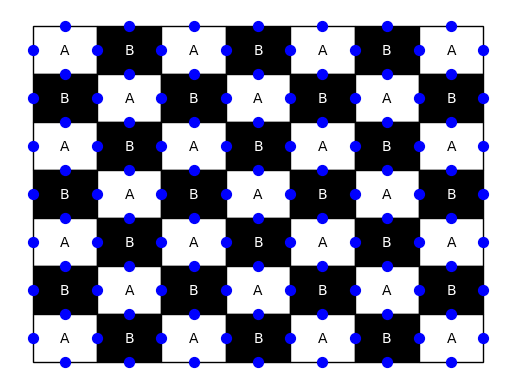

In [4]:
#array of A,B and the x and y shifts
Lx = 7; Ly = 7; #this is the max that can be done. 
#this is the plaquette values
array_AB = [['' for i in range(Ly)] for j in range(Lx)]
for ix in range(Lx):
    for iy in range(Ly):
        if ix%2 == 0:
            if iy%2 == 0:
                array_AB[ix][iy] = 'A'
            else:
                array_AB[ix][iy] = 'B'
        else:
            if iy%2 == 0:
                array_AB[ix][iy] = 'B'
            else:
                array_AB[ix][iy] = 'A'
array_AB = np.array(array_AB)


#####
#plotting the A/B sublattice structure
#####
ybond_qubit = np.ones((Lx, Ly+1))
xbond_qubit = np.ones((Lx+1, Ly))

fig, ax = subplots()
ax.set_axis_off()
for (row_idx, col_idx), cell_val in np.ndenumerate(ybond_qubit):
    ax.scatter([0.5 + row_idx], [col_idx], s=50, color = 'blue')

for (row_idx, col_idx), cell_val in np.ndenumerate(xbond_qubit):
    ax.scatter([row_idx], [0.5+ col_idx], s=50, color = 'blue')


cell_colors=("white", "black")
font_colors=("black", "white")
delta = 1/11/2
tb = Table(ax, bbox = [delta, delta, 1 - 2*delta, 1-2*delta])
n_rows, n_cols = array_AB.shape
width, height = 1.0/(n_rows + 1) , 1.0/(n_cols + 1)
for (row_idx, col_idx), cell_val in np.ndenumerate(array_AB):
    idx = (col_idx + row_idx) % 2
    if cell_val == 'A':
        ind = 0
    else:
        ind = 1
    tb.add_cell(
        row_idx,
        col_idx,
        width,
        height,
        text=cell_val,
        loc="center",
        facecolor=cell_colors[ind],
    )
    tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[ind])

ax.add_table(tb)


For each sublattice, we need an even (P = 1) and an odd (P = -1) parity encoding. The next two sections develop those by hand. Since each 'A' site only touches other 'B' sites, the embeddings of the parity gadgets on 'A' and 'B' cells needs to be compatible. By that, we mean that the physical qubits (in blue, which reside on the edges) are shared between 'A' and 'B' embeddings, while the ancilla structure do not overlap.

# Sublattice A embeddings

#### Odd parity embedding : sublattice A

Relies on a single 4-chain as an ancilla, and everything can be done on a unit cell of the Zephyr graph. This is inspired from all the Lechner papers (in particular, the implementation on neutral atoms)

Requires no local magnetic field

In [5]:
edges_chain = [(51, 532), (55, 532), (528, 55), (528, 51)]
edges_dominant = [(43, 532), (43, 528),(51, 520), (51, 524), (47, 528), (47, 532), (55, 520), (55,524)]
edges_intra = [(43,520), (43,524), (520,47), (524, 47)]
edges_diagonal = [(43, 47), (520,524)]

all_edges = edges_chain + edges_dominant + edges_intra + edges_diagonal
J_dict = {}
for e in all_edges:
    if e in edges_chain:
        jval = -2
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_dominant:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_intra:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_diagonal:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)

sites = []
for ed in all_edges:
    sites.append(ed[0])
    sites.append(ed[1])
res = [*set(sites)]

h_dict = {}
for i in res:
    h_dict.update({i:0})    

In [7]:
print(J_dict)
print(h_dict)

{(51, 532): -2, (55, 532): -2, (55, 528): -2, (51, 528): -2, (43, 532): 1, (43, 528): 1, (51, 520): 1, (51, 524): 1, (47, 528): 1, (47, 532): 1, (55, 520): 1, (55, 524): 1, (43, 520): 1, (43, 524): 1, (47, 520): 1, (47, 524): 1, (43, 47): 1, (520, 524): 1}
{520: 0, 43: 0, 524: 0, 47: 0, 528: 0, 51: 0, 532: 0, 55: 0}


Return the simplified graph of the embedding

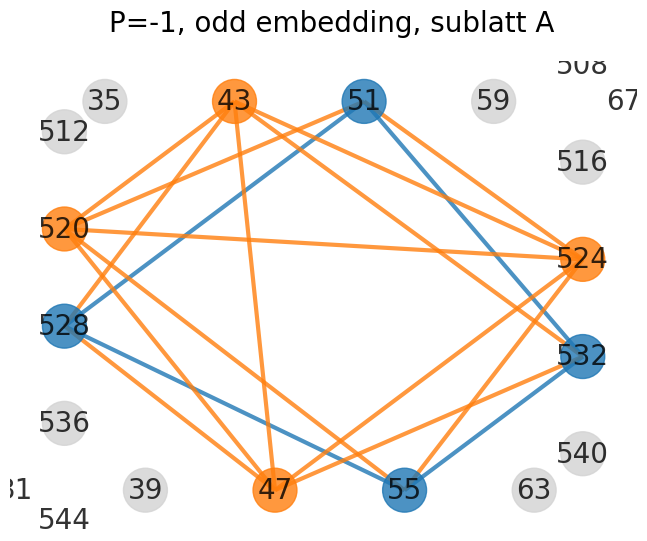

In [6]:
all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
edges_draw = [key for key in J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if ed in edges_chain or Reverse(ed) in edges_chain:
        edge_colors.append(all_colors[0])
    else:
        edge_colors.append(all_colors[1])

absent = [512, 536, 35, 59, 540, 516, 39, 63]
res_v2 = res + absent 

node_colors = []
qubits_measure =  [520, 43, 47, 524] #majority rule
for site in res_v2:
    if site in qubits_measure:
        node_colors.append(all_colors[1])
    elif site in absent:
        node_colors.append('#D3D3D3')
    else:
        node_colors.append(all_colors[0])

G = dnx.zephyr_graph(4)
plt.ion()
plt.axis("off")
plt.title("P=-1, odd embedding, sublatt A", x=0.5, y=1.2, fontsize = 20)
dnx.draw_zephyr(G, nodelist = res_v2, width = 3, node_size = 1000, edgelist = edges_draw, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8, edge_color = edge_colors)

In [8]:
#run it
run_true_or_false = True
if run_true_or_false:
    num_reads = 200
    response = sampler.sample_ising(h = {}, J=J_dict,
                                                num_reads=num_reads,
                                                annealing_time=100,
                                                answer_mode="raw", num_spin_reversal_transforms = 10)

    #dwave.inspector.show(response)


In [9]:
dwave.inspector.show(response)

Serving Inspector on http://127.0.0.1:18000/?problemId=2532fe04-4eca-4605-924f-126431e82682

'http://127.0.0.1:18000/?problemId=2532fe04-4eca-4605-924f-126431e82682'

this is also more realiable: as can be seen below in the histogram.

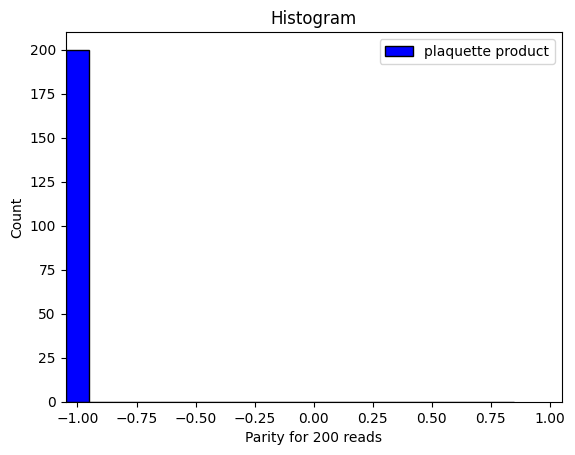

In [10]:
#the index of the plaquette qubit
inds_qb_plaquettes = []
qubits_measure =  [520, 43, 47, 524] #majority rule
for j in qubits_measure:
    inds_qb_plaquettes.append(response.variables.index(j))

plaq_values = []
for resp in response.record:
    plaq_values.append(np.prod(resp[0][inds_qb_plaquettes]))
#plaq_values

# Create histogram
bin_range = np.arange(-1, 1, 0.1) - 0.05
plt.hist(np.array(plaq_values), bins=bin_range, edgecolor='black', color = 'blue', label = 'plaquette product')

# Customize labels and title
plt.xlabel('Parity for 200 reads')
plt.ylabel('Count')
plt.title('Histogram')
plt.xlim([-1.05, 1.05])
plt.legend()
# Display the histogram
plt.show()



### Even parity encoding : Sublattice A

This version relies on one three chain and two single ancillas - it is a single unit-cell version of the Lechner gadget. 3 ancillas are needed for 4 qubits - one of the ancillas is realized as a 2-chain. 

In [4]:
edges_chain = [(51, 528)]
edges_dominant = [(55, 524), (520, 55), (51, 55), (528, 532), (43, 532), (47, 532)]
edges_intra = [(520, 51), (520, 524), (43, 528), (524, 51), (43, 47), (528, 47)]

ancilla_sites = [532, 55]
ancilla_sites_chain = [51, 528]
qubit_sites = [520, 43, 47, 524]

all_edges = edges_chain + edges_dominant + edges_intra 
J_dict = {}
for e in all_edges:
    if e in edges_chain:
        # jval = -4
        jval = -2
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_dominant:
        # jval = 2
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_intra:
        # jval = 1
        jval = 0.5
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)

all_sites = ancilla_sites + qubit_sites + ancilla_sites_chain
h_dict = {}
for i in all_sites:
    if i in ancilla_sites:
        # h_dict.update({i:-2})
        h_dict.update({i:-1})
    elif i in ancilla_sites_chain:
        # h_dict.update({i:-1})
        h_dict.update({i:-0.5})
    elif i in qubit_sites:
        # h_dict.update({i:-1})
        h_dict.update({i:-0.5})

In [12]:
print(J_dict)
print(h_dict)

{(51, 528): -4, (55, 524): 2, (55, 520): 2, (51, 55): 2, (528, 532): 2, (43, 532): 2, (47, 532): 2, (51, 520): 1, (520, 524): 1, (43, 528): 1, (51, 524): 1, (43, 47): 1, (47, 528): 1}
{532: -2, 55: -2, 520: -1, 43: -1, 47: -1, 524: -1, 51: -1, 528: -1}


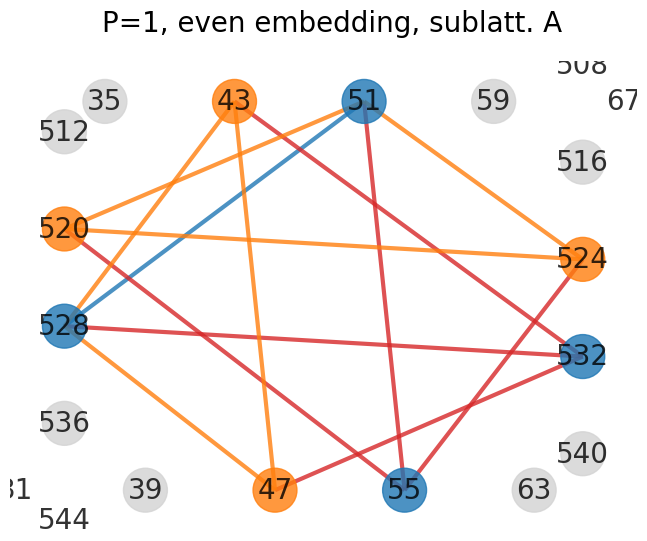

In [5]:
sites = []
for ed in all_edges:
    sites.append(ed[0])
    sites.append(ed[1])
res = [*set(sites)]
#print(res)

all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
edges_draw = [key for key in J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if ed in edges_chain or Reverse(ed) in edges_chain:
        edge_colors.append(all_colors[0])
    elif ed in edges_dominant or Reverse(ed) in edges_dominant:
        edge_colors.append(all_colors[3])
    else:
        edge_colors.append(all_colors[1])

absent = [512, 536, 35, 59, 540, 516, 39, 63]
res_v2 = res + absent 

node_colors = []
for site in res_v2:
    if site in qubit_sites:
        node_colors.append(all_colors[1])
    elif site in absent:
        node_colors.append('#D3D3D3')
    else:
        node_colors.append(all_colors[0])

G = dnx.zephyr_graph(4)
plt.ion()
plt.axis("off")
plt.title("P=1, even embedding, sublatt. A", x=0.5, y=1.2, fontsize = 20)
dnx.draw_zephyr(G, nodelist = res_v2, width = 3, node_size = 1000, edgelist = edges_draw, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8, edge_color = edge_colors)

In [6]:
#run it
run_true_or_false = True
if run_true_or_false:
    num_reads = 200
    response = sampler.sample_ising(h = h_dict, J=J_dict,
                                                num_reads=num_reads,
                                                annealing_time=100,
                                                answer_mode="raw", num_spin_reversal_transforms = 10)

    #dwave.inspector.show(response)

In [7]:
dwave.inspector.show(response)

Serving Inspector on http://127.0.0.1:18000/?problemId=b222918e-9324-4f65-b181-40a2d4907f0e

'http://127.0.0.1:18000/?problemId=b222918e-9324-4f65-b181-40a2d4907f0e'

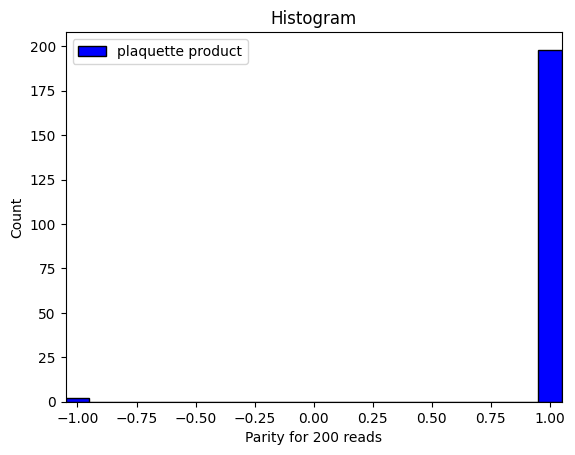

In [8]:
#the index of the plaquette qubit
inds_qb_plaquettes = []
for j in qubit_sites:
    inds_qb_plaquettes.append(response.variables.index(j))

plaq_values = []
for resp in response.record:
    plaq_values.append(np.prod(resp[0][inds_qb_plaquettes]))
#plaq_values

# Create histogram
bin_range = np.arange(-1, 2, 0.1) - 0.05
plt.hist(np.array(plaq_values), bins=bin_range, edgecolor='black', color = 'blue', label = 'plaquette product')

# Customize labels and title
plt.xlabel('Parity for 200 reads')
plt.ylabel('Count')
plt.title('Histogram')
plt.xlim([-1.05, 1.05])
plt.legend()
# Display the histogram
plt.show()



# Sublattice B embeddings

#### Odd parity embedding : sublattice B


In [78]:
edges_chain = [(59, 516), (63, 516), (512, 63), (512, 59)]
edges_dominant = [(43, 516), (43, 512),(59, 520), (59, 524), (47, 512), (47, 516), (63, 520), (63,524)]
edges_intra = [(43,520), (43,524), (520,47), (524, 47)]
edges_diagonal = [(43, 47), (520,524)]

all_edges = edges_chain + edges_dominant + edges_intra + edges_diagonal
J_dict = {}
for e in all_edges:
    if e in edges_chain:
        jval = -2
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_dominant:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_intra:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_diagonal:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)

Return the simplified graph of the embedding

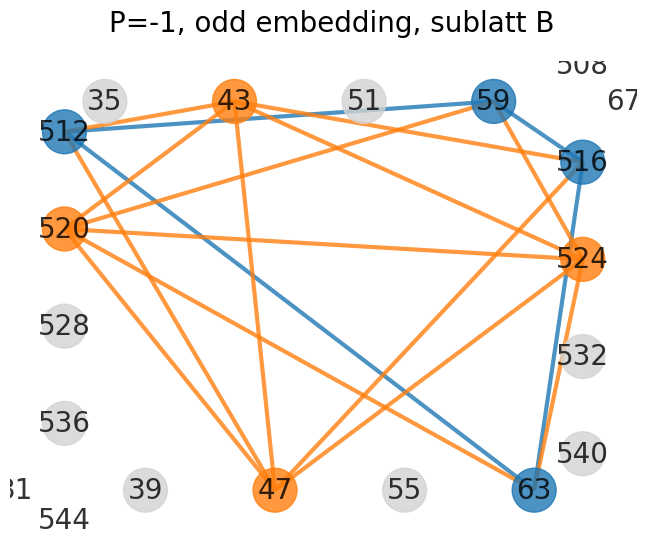

In [75]:
sites = []
for ed in all_edges:
    sites.append(ed[0])
    sites.append(ed[1])
res = [*set(sites)]
#print(res)

all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
edges_draw = [key for key in J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if ed in edges_chain or Reverse(ed) in edges_chain:
        edge_colors.append(all_colors[0])
    else:
        edge_colors.append(all_colors[1])

absent = [528, 536, 35, 51, 532, 540, 55, 39]
res_v2 = res + absent 

node_colors = []
qubits_measure =  [520, 43, 47, 524] #majority rule
for site in res_v2:
    if site in qubits_measure:
        node_colors.append(all_colors[1])
    elif site in absent:
        node_colors.append('#D3D3D3')
    else:
        node_colors.append(all_colors[0])

G = dnx.zephyr_graph(4)
plt.ion()
plt.axis("off")
plt.title("P=-1, odd embedding, sublatt B", x=0.5, y=1.2, fontsize = 20)
dnx.draw_zephyr(G, nodelist = res_v2, width = 3, node_size = 1000, edgelist = edges_draw, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8, edge_color = edge_colors)

In [76]:
#run it
run_true_or_false = True
if run_true_or_false:
    num_reads = 200
    response = sampler.sample_ising(h = {}, J=J_dict,
                                                num_reads=num_reads,
                                                annealing_time=100,
                                                answer_mode="raw", num_spin_reversal_transforms = 10)

    #dwave.inspector.show(response)


this is also more realiable: as can be seen below in the histogram.

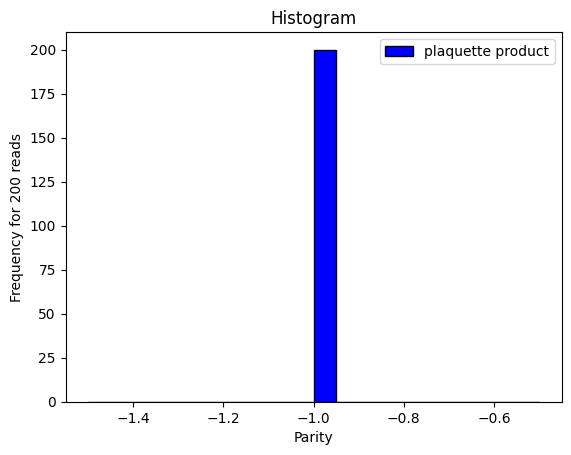

In [19]:
#the index of the plaquette qubit
inds_qb_plaquettes = []
qubits_measure =  [520, 43, 47, 524] #majority rule
for j in qubits_measure:
    inds_qb_plaquettes.append(response.variables.index(j))

plaq_values = []
for resp in response.record:
    plaq_values.append(np.prod(resp[0][inds_qb_plaquettes]))
#plaq_values

# Create histogram
plt.hist(np.array(plaq_values), bins=20, edgecolor='black', color = 'blue', label = 'plaquette product')

# Customize labels and title
plt.xlabel('Parity')
plt.ylabel('Frequency for 200 reads')
plt.title('Histogram')
plt.legend()
# Display the histogram
plt.show()



### Even parity encoding : Sublattice B

In [20]:
edges_chain = [(59, 512)]
edges_dominant = [(63, 524), (520, 63), (59, 63), (512, 516), (43, 516), (47, 516)]
edges_intra = [(520, 59), (520, 524), (43, 512), (524, 59), (43, 47), (512, 47)]

ancilla_sites = [516, 63]
ancilla_sites_chain = [59, 512]
qubit_sites = [520, 43, 47, 524]

all_edges = edges_chain + edges_dominant + edges_intra 
J_dict = {}
for e in all_edges:
    if e in edges_chain:
        jval = -4
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_dominant:
        jval = 2
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_intra:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)

all_sites = ancilla_sites + qubit_sites
h_dict = {}
for i in all_sites:
    if i in ancilla_sites:
        h_dict.update({i:-2})
    elif i in ancilla_sites_chain:
        h_dict.update({i:-1})
    elif i in qubit_sites:
        h_dict.update({i:-1})

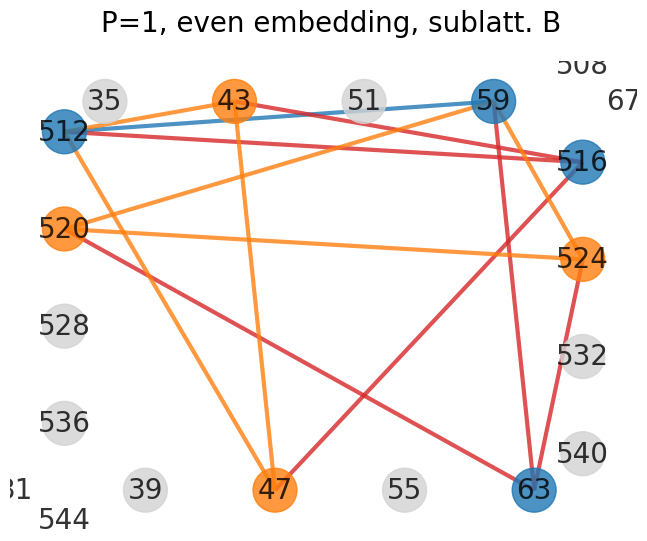

In [21]:
sites = []
for ed in all_edges:
    sites.append(ed[0])
    sites.append(ed[1])
res = [*set(sites)]
#print(res)

all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
edges_draw = [key for key in J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if ed in edges_chain or Reverse(ed) in edges_chain:
        edge_colors.append(all_colors[0])
    elif ed in edges_dominant or Reverse(ed) in edges_dominant:
        edge_colors.append(all_colors[3])
    else:
        edge_colors.append(all_colors[1])

absent = [528, 536, 35, 51, 540, 532, 39, 55]
res_v2 = res + absent 

node_colors = []
for site in res_v2:
    if site in qubit_sites:
        node_colors.append(all_colors[1])
    elif site in absent:
        node_colors.append('#D3D3D3')
    else:
        node_colors.append(all_colors[0])

G = dnx.zephyr_graph(4)
plt.ion()
plt.axis("off")
plt.title("P=1, even embedding, sublatt. B", x=0.5, y=1.2, fontsize = 20)
dnx.draw_zephyr(G, nodelist = res_v2, width = 3, node_size = 1000, edgelist = edges_draw, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8, edge_color = edge_colors)

In [22]:
#run it
run_true_or_false = True
if run_true_or_false:
    num_reads = 200
    response = sampler.sample_ising(h = h_dict, J=J_dict,
                                                num_reads=num_reads,
                                                annealing_time=100,
                                                answer_mode="raw", num_spin_reversal_transforms = 10)

    #dwave.inspector.show(response)

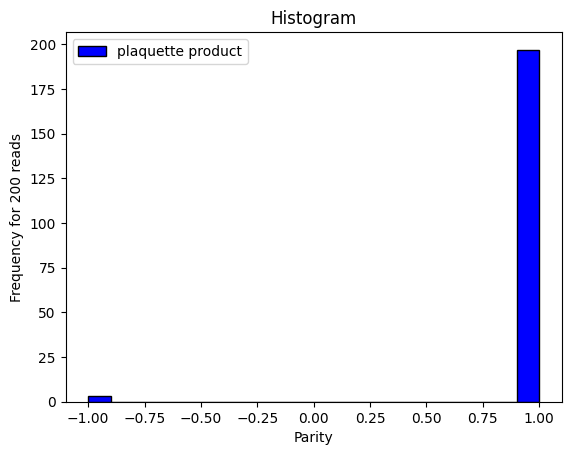

In [23]:
#the index of the plaquette qubit
inds_qb_plaquettes = []
for j in qubit_sites:
    inds_qb_plaquettes.append(response.variables.index(j))

plaq_values = []
for resp in response.record:
    plaq_values.append(np.prod(resp[0][inds_qb_plaquettes]))
#plaq_values

# Create histogram
plt.hist(np.array(plaq_values), bins=20, edgecolor='black', color = 'blue', label = 'plaquette product')

# Customize labels and title
plt.xlabel('Parity')
plt.ylabel('Frequency for 200 reads')
plt.title('Histogram')
plt.legend()
# Display the histogram
plt.show()



# Stitching it all together:


### Firstly, a function that does any embedding

To this function, we need to feed a sublattice type (A or B, string), a parity (integer 1 or -1), the corner top left indices of the Zephyr box to represent the embedding in (the first box at cell (0,0) on the square lattice has corner_top_left_indices = [320, 32]). Finally we need to specify the type of X and Y shift for the vertical and horizontal connects. These shifts change cell by cell. See below for a structure of the shift in X and Y.

In [24]:
#missing ancillas are fixed by hand in this embedding function

def plaquette_embedding(sublatt, parity, corner_top_left_indices, tuple_shift):
    top_left_vertical = corner_top_left_indices[0]
    top_left_horizontal = corner_top_left_indices[1]
    shift_x = tuple_shift[0]
    shift_y = tuple_shift[1]

    plaquette_sites = [top_left_horizontal + 8, top_left_vertical + shift_x + 8, top_left_horizontal + 8 + shift_y, top_left_vertical + 8]
    ancilla_sites_B = [top_left_horizontal + 24, top_left_vertical + shift_x, top_left_horizontal + 24 + shift_y, top_left_vertical]
    ancilla_sites_A = [top_left_horizontal + 16, top_left_vertical + shift_x + 16, top_left_horizontal + 16 + shift_y, top_left_vertical + 16]
    J_dict = {}
    h_dict = {}
    missing_coupler = {}
    missing_qubits = {}

    J_couplers_even = [-4, 2, 1]
    J_couplers_odd = [-2,1, 1]

    #special cells
    #[[420, 69], [483, 230]]
    weird_cells_horizontal_index = [69, 230]

    #problematic cells - can be fed in at function level
    #and then there are 2 types of embedding for each case:
    #   -whether corner_top_left_indices[1] not in problematic cells
    #   -wether it is in


    if corner_top_left_indices[1] not in weird_cells_horizontal_index:

        if sublatt == 'A':
            ancilla_sites = ancilla_sites_A
            all_sites = ancilla_sites + plaquette_sites
            if parity == 1:
                chain_sites = [top_left_horizontal + 16, top_left_vertical + 16]
                #even embedding
                edges_chain = [(top_left_horizontal + 16, top_left_vertical + 16)]
                edges_dominant = [(top_left_horizontal + 16 + shift_y, top_left_horizontal + 16), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 8),
                (top_left_vertical + shift_x + 16, top_left_horizontal + 8),
                (top_left_vertical + shift_x + 16, top_left_horizontal + 8 + shift_y),
                (top_left_vertical + shift_x + 16, top_left_vertical + 16)]
                edges_intra = [(top_left_horizontal + 16, top_left_vertical + shift_x + 8),
                (top_left_vertical + shift_x + 8, top_left_vertical + 8),
                (top_left_vertical + 8, top_left_horizontal + 16),
                (top_left_vertical + 16, top_left_horizontal + 8),
                (top_left_horizontal + 8, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 16)]

                all_edges = edges_chain + edges_dominant + edges_intra 
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_even[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_dominant:
                        jval = J_couplers_even[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_even[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i in ancilla_sites:
                        if i in chain_sites:
                            if i in sampler.nodelist:
                                h_dict.update({i:-1})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-1})
                        else:
                            if i in sampler.nodelist:
                                h_dict.update({i:-2})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-2})
                    elif i in plaquette_sites:
                        if i in sampler.nodelist:
                            h_dict.update({i:-1})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-1})
            elif parity == -1:
                #even embedding
                edges_chain = [(top_left_horizontal + 16, top_left_vertical + shift_x + 16), 
                (top_left_vertical + shift_x + 16, top_left_horizontal + 16 + shift_y), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 16),
                (top_left_vertical + 16, top_left_horizontal + 16)]
                edges_inter = [(top_left_horizontal + 8, top_left_vertical + shift_x + 8),
                (top_left_horizontal + 8, top_left_vertical + 8),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8), 
                (top_left_horizontal + 8 + shift_y, top_left_horizontal + 8), 
                (top_left_vertical + 8 + shift_x, top_left_vertical + 8)]

                edges_intra = [(top_left_horizontal + 16, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 16, top_left_vertical + 8), 
                (top_left_vertical + shift_x + 16, top_left_horizontal + 8), 
                (top_left_vertical + shift_x + 16, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 16 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 8),
                (top_left_vertical + 16, top_left_horizontal + 8),
                (top_left_vertical + 16, top_left_horizontal + 8 + shift_y)]

                all_edges = edges_chain + edges_intra + edges_inter
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_odd[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_odd[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_inter:
                        jval = J_couplers_odd[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i not in sampler.nodelist:
                        #print("problem with ", i)
                        missing_qubits.update({i:0})
                    else:
                        h_dict.update({i:0})
        elif sublatt == 'B':
            ancilla_sites = ancilla_sites_B
            all_sites = ancilla_sites + plaquette_sites
            if parity == 1:
                chain_sites = [top_left_horizontal + 24, top_left_vertical]
                #even embedding
                edges_chain = [(top_left_horizontal + 24, top_left_vertical)]
                edges_dominant = [(top_left_horizontal + 24 + shift_y, top_left_horizontal + 24), 
                (top_left_horizontal + 24 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 24 + shift_y, top_left_vertical + 8),
                (top_left_vertical + shift_x, top_left_horizontal + 8),
                (top_left_vertical + shift_x, top_left_horizontal + 8 + shift_y),
                (top_left_vertical + shift_x, top_left_vertical)]
                edges_intra = [(top_left_horizontal + 24, top_left_vertical + shift_x + 8),
                (top_left_vertical + shift_x + 8, top_left_vertical + 8),
                (top_left_vertical + 8, top_left_horizontal + 24),
                (top_left_vertical, top_left_horizontal + 8),
                (top_left_horizontal + 8, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 8 + shift_y, top_left_vertical)]

                all_edges = edges_chain + edges_dominant + edges_intra 
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_even[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_dominant:
                        jval = J_couplers_even[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_even[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i in ancilla_sites:
                        if i in chain_sites:
                            if i in sampler.nodelist:
                                h_dict.update({i:-1})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-1})
                        else:
                            if i in sampler.nodelist:
                                h_dict.update({i:-2})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-2})
                    elif i in plaquette_sites:
                        if i in sampler.nodelist:
                            h_dict.update({i:-1})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-1})
            elif parity == -1:
                #even embedding
                edges_chain = [(top_left_horizontal + 24, top_left_vertical + shift_x), 
                (top_left_vertical + shift_x, top_left_horizontal + 24 + shift_y), 
                (top_left_horizontal + 24 + shift_y, top_left_vertical),
                (top_left_vertical, top_left_horizontal + 24)]
                edges_inter = [(top_left_horizontal + 8, top_left_vertical + shift_x + 8),
                (top_left_horizontal + 8, top_left_vertical + 8),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8), 
                (top_left_horizontal + 8 + shift_y, top_left_horizontal + 8), 
                (top_left_vertical + 8 + shift_x, top_left_vertical + 8)]

                edges_intra = [(top_left_horizontal + 24, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 24, top_left_vertical + 8), 
                (top_left_vertical + shift_x, top_left_horizontal + 8), 
                (top_left_vertical + shift_x, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 24 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 24 + shift_y, top_left_vertical + 8),
                (top_left_vertical, top_left_horizontal + 8),
                (top_left_vertical, top_left_horizontal + 8 + shift_y)]

                all_edges = edges_chain + edges_intra + edges_inter
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_odd[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_odd[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_inter:
                        jval = J_couplers_odd[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                
                for i in all_sites:
                    if i not in sampler.nodelist:
                        #print("problem with ", i)
                        missing_qubits.update({i:0})
                    else:
                        h_dict.update({i:0})
    else:
        if corner_top_left_indices[1] == 69:
            #this is an A sublattice, modified
            #initial ancilla structure
            #ancilla_sites_B = [top_left_horizontal + 24, top_left_vertical + shift_x, top_left_horizontal + 24 + shift_y, top_left_vertical]
            #ancilla_sites_A = [top_left_horizontal + 16, top_left_vertical + shift_x + 16, top_left_horizontal + 16 + shift_y, top_left_vertical + 16]
            ancilla_sites = [top_left_horizontal + 16, top_left_vertical + shift_x + 24, top_left_horizontal + 16 + shift_y, top_left_vertical + 24]
            all_sites = ancilla_sites + plaquette_sites
            if parity == 1:
                chain_sites = [top_left_horizontal + 16, top_left_vertical + 24]
                #even embedding
                edges_chain = [(top_left_horizontal + 16, top_left_vertical + 24)]
                #these are the J = 2
                edges_dominant = [(top_left_horizontal + 16 + shift_y, top_left_horizontal + 16), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 8),
                (top_left_vertical + shift_x + 24, top_left_horizontal + 8),
                (top_left_vertical + shift_x + 24, top_left_horizontal + 8 + shift_y),
                (top_left_vertical + shift_x + 24, top_left_vertical + 24)]
                edges_intra = [(top_left_horizontal + 16, top_left_vertical + shift_x + 8),
                (top_left_vertical + shift_x + 8, top_left_vertical + 8),
                (top_left_vertical + 8, top_left_horizontal + 16),
                (top_left_vertical + 24, top_left_horizontal + 8),
                (top_left_horizontal + 8, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 24)]

                all_edges = edges_chain + edges_dominant + edges_intra 
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_even[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_dominant:
                        jval = J_couplers_even[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_even[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i in ancilla_sites:
                        if i in chain_sites:
                            if i in sampler.nodelist:
                                h_dict.update({i:-1})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-1})
                        else:
                            if i in sampler.nodelist:
                                h_dict.update({i:-2})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-2})
                    elif i in plaquette_sites:
                        if i in sampler.nodelist:
                            h_dict.update({i:-1})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-1})
            elif parity == -1:
                #even embedding
                edges_chain = [(top_left_horizontal + 16, top_left_vertical + shift_x + 24), 
                (top_left_vertical + shift_x + 24, top_left_horizontal + 16 + shift_y), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 24),
                (top_left_vertical + 24, top_left_horizontal + 16)]
                edges_inter = [(top_left_horizontal + 8, top_left_vertical + shift_x + 8),
                (top_left_horizontal + 8, top_left_vertical + 8),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8), 
                (top_left_horizontal + 8 + shift_y, top_left_horizontal + 8), 
                (top_left_vertical + 8 + shift_x, top_left_vertical + 8)]

                edges_intra = [(top_left_horizontal + 16, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 16, top_left_vertical + 8), 
                (top_left_vertical + shift_x + 24, top_left_horizontal + 8), 
                (top_left_vertical + shift_x + 24, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 16 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 8),
                (top_left_vertical + 24, top_left_horizontal + 8),
                (top_left_vertical + 24, top_left_horizontal + 8 + shift_y)]

                all_edges = edges_chain + edges_intra + edges_inter
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_odd[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_odd[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_inter:
                        jval = J_couplers_odd[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i not in sampler.nodelist:
                        #print("problem with ", i)
                        missing_qubits.update({i:0})
                    else:
                        h_dict.update({i:0})

        elif corner_top_left_indices[1] == 230:
            #this is a B sublattice
            #ancilla_sites_B = [top_left_horizontal + 24, top_left_vertical + shift_x, top_left_horizontal + 24 + shift_y, top_left_vertical]
            #ancilla_sites_A = [top_left_horizontal + 16, top_left_vertical + shift_x + 16, top_left_horizontal + 16 + shift_y, top_left_vertical + 16]
            ancilla_sites = [top_left_horizontal, top_left_vertical + shift_x, top_left_horizontal + shift_y, top_left_vertical]
            all_sites = ancilla_sites + plaquette_sites
            if parity == 1:
                chain_sites = [top_left_horizontal, top_left_vertical]
                #even embedding
                edges_chain = [(top_left_horizontal, top_left_vertical)]
                edges_dominant = [(top_left_horizontal + shift_y, top_left_horizontal), 
                (top_left_horizontal + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + shift_y, top_left_vertical + 8),
                (top_left_vertical + shift_x, top_left_horizontal + 8),
                (top_left_vertical + shift_x, top_left_horizontal + 8 + shift_y),
                (top_left_vertical + shift_x, top_left_vertical)]
                edges_intra = [(top_left_horizontal, top_left_vertical + shift_x + 8),
                (top_left_vertical + shift_x + 8, top_left_vertical + 8),
                (top_left_vertical + 8, top_left_horizontal),
                (top_left_vertical, top_left_horizontal + 8),
                (top_left_horizontal + 8, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 8 + shift_y, top_left_vertical)]

                all_edges = edges_chain + edges_dominant + edges_intra 
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_even[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_dominant:
                        jval = J_couplers_even[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_even[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i in ancilla_sites:
                        if i in chain_sites:
                            if i in sampler.nodelist:
                                h_dict.update({i:-1})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-1})
                        else:
                            if i in sampler.nodelist:
                                h_dict.update({i:-2})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-2})
                    elif i in plaquette_sites:
                        if i in sampler.nodelist:
                            h_dict.update({i:-1})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-1})
            elif parity == -1:
                #even embedding
                edges_chain = [(top_left_horizontal, top_left_vertical + shift_x), 
                (top_left_vertical + shift_x, top_left_horizontal + shift_y), 
                (top_left_horizontal + shift_y, top_left_vertical),
                (top_left_vertical, top_left_horizontal)]
                edges_inter = [(top_left_horizontal + 8, top_left_vertical + shift_x + 8),
                (top_left_horizontal + 8, top_left_vertical + 8),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8), 
                (top_left_horizontal + 8 + shift_y, top_left_horizontal + 8), 
                (top_left_vertical + 8 + shift_x, top_left_vertical + 8)]

                edges_intra = [(top_left_horizontal, top_left_vertical + 8 + shift_x),
                (top_left_horizontal, top_left_vertical + 8), 
                (top_left_vertical + shift_x, top_left_horizontal + 8), 
                (top_left_vertical + shift_x, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + shift_y, top_left_vertical + 8),
                (top_left_vertical, top_left_horizontal + 8),
                (top_left_vertical, top_left_horizontal + 8 + shift_y)]

                all_edges = edges_chain + edges_intra + edges_inter
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_odd[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_odd[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_inter:
                        jval = J_couplers_odd[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                
                for i in all_sites:
                    if i not in sampler.nodelist:
                        #print("problem with ", i)
                        missing_qubits.update({i:0})
                    else:
                        h_dict.update({i:0})

    return h_dict, J_dict, plaquette_sites, ancilla_sites, missing_coupler, missing_qubits


In [25]:
#missing ancillas are fixed by hand in this embedding function

def plaquette_embedding_walternate(sublatt, parity, corner_top_left_indices, tuple_shift, weird_cells_horizontal_index):
    top_left_vertical = corner_top_left_indices[0]
    top_left_horizontal = corner_top_left_indices[1]
    shift_x = tuple_shift[0]
    shift_y = tuple_shift[1]

    plaquette_sites = [top_left_horizontal + 8, top_left_vertical + shift_x + 8, top_left_horizontal + 8 + shift_y, top_left_vertical + 8]
    ancilla_sites_B = [top_left_horizontal + 24, top_left_vertical + shift_x, top_left_horizontal + 24 + shift_y, top_left_vertical]
    ancilla_sites_A = [top_left_horizontal + 16, top_left_vertical + shift_x + 16, top_left_horizontal + 16 + shift_y, top_left_vertical + 16]
    J_dict = {}
    h_dict = {}
    missing_coupler = {}
    missing_qubits = {}

    J_couplers_even = [-4, 2, 1]
    J_couplers_odd = [-2,1, 1]

    #special cells
    #[[420, 69], [483, 230]]
    #weird_cells_horizontal_index = [69, 230]

    #problematic cells - can be fed in at function level
    #and then there are 2 types of embedding for each case:
    #   -whether corner_top_left_indices[1] not in problematic cells
    #   -wether it is in


    if corner_top_left_indices[1] not in weird_cells_horizontal_index:

        if sublatt == 'A':
            ancilla_sites = ancilla_sites_A
            all_sites = ancilla_sites + plaquette_sites
            if parity == 1:
                chain_sites = [top_left_horizontal + 16, top_left_vertical + 16]
                #even embedding
                edges_chain = [(top_left_horizontal + 16, top_left_vertical + 16)]
                edges_dominant = [(top_left_horizontal + 16 + shift_y, top_left_horizontal + 16), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 8),
                (top_left_vertical + shift_x + 16, top_left_horizontal + 8),
                (top_left_vertical + shift_x + 16, top_left_horizontal + 8 + shift_y),
                (top_left_vertical + shift_x + 16, top_left_vertical + 16)]
                edges_intra = [(top_left_horizontal + 16, top_left_vertical + shift_x + 8),
                (top_left_vertical + shift_x + 8, top_left_vertical + 8),
                (top_left_vertical + 8, top_left_horizontal + 16),
                (top_left_vertical + 16, top_left_horizontal + 8),
                (top_left_horizontal + 8, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 16)]

                all_edges = edges_chain + edges_dominant + edges_intra 
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_even[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_dominant:
                        jval = J_couplers_even[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_even[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i in ancilla_sites:
                        if i in chain_sites:
                            if i in sampler.nodelist:
                                h_dict.update({i:-1})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-1})
                        else:
                            if i in sampler.nodelist:
                                h_dict.update({i:-2})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-2})
                    elif i in plaquette_sites:
                        if i in sampler.nodelist:
                            h_dict.update({i:-1})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-1})
            elif parity == -1:
                #even embedding
                edges_chain = [(top_left_horizontal + 16, top_left_vertical + shift_x + 16), 
                (top_left_vertical + shift_x + 16, top_left_horizontal + 16 + shift_y), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 16),
                (top_left_vertical + 16, top_left_horizontal + 16)]
                edges_inter = [(top_left_horizontal + 8, top_left_vertical + shift_x + 8),
                (top_left_horizontal + 8, top_left_vertical + 8),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8), 
                (top_left_horizontal + 8 + shift_y, top_left_horizontal + 8), 
                (top_left_vertical + 8 + shift_x, top_left_vertical + 8)]

                edges_intra = [(top_left_horizontal + 16, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 16, top_left_vertical + 8), 
                (top_left_vertical + shift_x + 16, top_left_horizontal + 8), 
                (top_left_vertical + shift_x + 16, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 16 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 8),
                (top_left_vertical + 16, top_left_horizontal + 8),
                (top_left_vertical + 16, top_left_horizontal + 8 + shift_y)]

                all_edges = edges_chain + edges_intra + edges_inter
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_odd[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_odd[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_inter:
                        jval = J_couplers_odd[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i not in sampler.nodelist:
                        #print("problem with ", i)
                        missing_qubits.update({i:0})
                    else:
                        h_dict.update({i:0})
        elif sublatt == 'B':
            ancilla_sites = ancilla_sites_B
            all_sites = ancilla_sites + plaquette_sites
            if parity == 1:
                chain_sites = [top_left_horizontal + 24, top_left_vertical]
                #even embedding
                edges_chain = [(top_left_horizontal + 24, top_left_vertical)]
                edges_dominant = [(top_left_horizontal + 24 + shift_y, top_left_horizontal + 24), 
                (top_left_horizontal + 24 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 24 + shift_y, top_left_vertical + 8),
                (top_left_vertical + shift_x, top_left_horizontal + 8),
                (top_left_vertical + shift_x, top_left_horizontal + 8 + shift_y),
                (top_left_vertical + shift_x, top_left_vertical)]
                edges_intra = [(top_left_horizontal + 24, top_left_vertical + shift_x + 8),
                (top_left_vertical + shift_x + 8, top_left_vertical + 8),
                (top_left_vertical + 8, top_left_horizontal + 24),
                (top_left_vertical, top_left_horizontal + 8),
                (top_left_horizontal + 8, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 8 + shift_y, top_left_vertical)]

                all_edges = edges_chain + edges_dominant + edges_intra 
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_even[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_dominant:
                        jval = J_couplers_even[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_even[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i in ancilla_sites:
                        if i in chain_sites:
                            if i in sampler.nodelist:
                                h_dict.update({i:-1})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-1})
                        else:
                            if i in sampler.nodelist:
                                h_dict.update({i:-2})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-2})
                    elif i in plaquette_sites:
                        if i in sampler.nodelist:
                            h_dict.update({i:-1})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-1})
            elif parity == -1:
                #even embedding
                edges_chain = [(top_left_horizontal + 24, top_left_vertical + shift_x), 
                (top_left_vertical + shift_x, top_left_horizontal + 24 + shift_y), 
                (top_left_horizontal + 24 + shift_y, top_left_vertical),
                (top_left_vertical, top_left_horizontal + 24)]
                edges_inter = [(top_left_horizontal + 8, top_left_vertical + shift_x + 8),
                (top_left_horizontal + 8, top_left_vertical + 8),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8), 
                (top_left_horizontal + 8 + shift_y, top_left_horizontal + 8), 
                (top_left_vertical + 8 + shift_x, top_left_vertical + 8)]

                edges_intra = [(top_left_horizontal + 24, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 24, top_left_vertical + 8), 
                (top_left_vertical + shift_x, top_left_horizontal + 8), 
                (top_left_vertical + shift_x, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 24 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 24 + shift_y, top_left_vertical + 8),
                (top_left_vertical, top_left_horizontal + 8),
                (top_left_vertical, top_left_horizontal + 8 + shift_y)]

                all_edges = edges_chain + edges_intra + edges_inter
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_odd[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_odd[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_inter:
                        jval = J_couplers_odd[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                
                for i in all_sites:
                    if i not in sampler.nodelist:
                        #print("problem with ", i)
                        missing_qubits.update({i:0})
                    else:
                        h_dict.update({i:0})
    else:
        if sublatt == 'A':
            #this is an A sublattice, modified
            #initial ancilla structure
            #ancilla_sites_B = [top_left_horizontal + 24, top_left_vertical + shift_x, top_left_horizontal + 24 + shift_y, top_left_vertical]
            #ancilla_sites_A = [top_left_horizontal + 16, top_left_vertical + shift_x + 16, top_left_horizontal + 16 + shift_y, top_left_vertical + 16]
            ancilla_sites = [top_left_horizontal + 16, top_left_vertical + shift_x + 24, top_left_horizontal + 16 + shift_y, top_left_vertical + 24]
            all_sites = ancilla_sites + plaquette_sites
            if parity == 1:
                chain_sites = [top_left_horizontal + 16, top_left_vertical + 24]
                #even embedding
                edges_chain = [(top_left_horizontal + 16, top_left_vertical + 24)]
                #these are the J = 2
                edges_dominant = [(top_left_horizontal + 16 + shift_y, top_left_horizontal + 16), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 8),
                (top_left_vertical + shift_x + 24, top_left_horizontal + 8),
                (top_left_vertical + shift_x + 24, top_left_horizontal + 8 + shift_y),
                (top_left_vertical + shift_x + 24, top_left_vertical + 24)]
                edges_intra = [(top_left_horizontal + 16, top_left_vertical + shift_x + 8),
                (top_left_vertical + shift_x + 8, top_left_vertical + 8),
                (top_left_vertical + 8, top_left_horizontal + 16),
                (top_left_vertical + 24, top_left_horizontal + 8),
                (top_left_horizontal + 8, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 24)]

                all_edges = edges_chain + edges_dominant + edges_intra 
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_even[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_dominant:
                        jval = J_couplers_even[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_even[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i in ancilla_sites:
                        if i in chain_sites:
                            if i in sampler.nodelist:
                                h_dict.update({i:-1})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-1})
                        else:
                            if i in sampler.nodelist:
                                h_dict.update({i:-2})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-2})
                    elif i in plaquette_sites:
                        if i in sampler.nodelist:
                            h_dict.update({i:-1})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-1})
            elif parity == -1:
                #even embedding
                edges_chain = [(top_left_horizontal + 16, top_left_vertical + shift_x + 24), 
                (top_left_vertical + shift_x + 24, top_left_horizontal + 16 + shift_y), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 24),
                (top_left_vertical + 24, top_left_horizontal + 16)]
                edges_inter = [(top_left_horizontal + 8, top_left_vertical + shift_x + 8),
                (top_left_horizontal + 8, top_left_vertical + 8),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8), 
                (top_left_horizontal + 8 + shift_y, top_left_horizontal + 8), 
                (top_left_vertical + 8 + shift_x, top_left_vertical + 8)]

                edges_intra = [(top_left_horizontal + 16, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 16, top_left_vertical + 8), 
                (top_left_vertical + shift_x + 24, top_left_horizontal + 8), 
                (top_left_vertical + shift_x + 24, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 16 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 8),
                (top_left_vertical + 24, top_left_horizontal + 8),
                (top_left_vertical + 24, top_left_horizontal + 8 + shift_y)]

                all_edges = edges_chain + edges_intra + edges_inter
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_odd[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_odd[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_inter:
                        jval = J_couplers_odd[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i not in sampler.nodelist:
                        #print("problem with ", i)
                        missing_qubits.update({i:0})
                    else:
                        h_dict.update({i:0})

        elif sublatt == 'B':
            #this is a B sublattice
            #ancilla_sites_B = [top_left_horizontal + 24, top_left_vertical + shift_x, top_left_horizontal + 24 + shift_y, top_left_vertical]
            #ancilla_sites_A = [top_left_horizontal + 16, top_left_vertical + shift_x + 16, top_left_horizontal + 16 + shift_y, top_left_vertical + 16]
            ancilla_sites = [top_left_horizontal, top_left_vertical + shift_x, top_left_horizontal + shift_y, top_left_vertical]
            all_sites = ancilla_sites + plaquette_sites
            if parity == 1:
                chain_sites = [top_left_horizontal, top_left_vertical]
                #even embedding
                edges_chain = [(top_left_horizontal, top_left_vertical)]
                edges_dominant = [(top_left_horizontal + shift_y, top_left_horizontal), 
                (top_left_horizontal + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + shift_y, top_left_vertical + 8),
                (top_left_vertical + shift_x, top_left_horizontal + 8),
                (top_left_vertical + shift_x, top_left_horizontal + 8 + shift_y),
                (top_left_vertical + shift_x, top_left_vertical)]
                edges_intra = [(top_left_horizontal, top_left_vertical + shift_x + 8),
                (top_left_vertical + shift_x + 8, top_left_vertical + 8),
                (top_left_vertical + 8, top_left_horizontal),
                (top_left_vertical, top_left_horizontal + 8),
                (top_left_horizontal + 8, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 8 + shift_y, top_left_vertical)]

                all_edges = edges_chain + edges_dominant + edges_intra 
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_even[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_dominant:
                        jval = J_couplers_even[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_even[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i in ancilla_sites:
                        if i in chain_sites:
                            if i in sampler.nodelist:
                                h_dict.update({i:-1})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-1})
                        else:
                            if i in sampler.nodelist:
                                h_dict.update({i:-2})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-2})
                    elif i in plaquette_sites:
                        if i in sampler.nodelist:
                            h_dict.update({i:-1})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-1})
            elif parity == -1:
                #even embedding
                edges_chain = [(top_left_horizontal, top_left_vertical + shift_x), 
                (top_left_vertical + shift_x, top_left_horizontal + shift_y), 
                (top_left_horizontal + shift_y, top_left_vertical),
                (top_left_vertical, top_left_horizontal)]
                edges_inter = [(top_left_horizontal + 8, top_left_vertical + shift_x + 8),
                (top_left_horizontal + 8, top_left_vertical + 8),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8), 
                (top_left_horizontal + 8 + shift_y, top_left_horizontal + 8), 
                (top_left_vertical + 8 + shift_x, top_left_vertical + 8)]

                edges_intra = [(top_left_horizontal, top_left_vertical + 8 + shift_x),
                (top_left_horizontal, top_left_vertical + 8), 
                (top_left_vertical + shift_x, top_left_horizontal + 8), 
                (top_left_vertical + shift_x, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + shift_y, top_left_vertical + 8),
                (top_left_vertical, top_left_horizontal + 8),
                (top_left_vertical, top_left_horizontal + 8 + shift_y)]

                all_edges = edges_chain + edges_intra + edges_inter
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_odd[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_odd[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_inter:
                        jval = J_couplers_odd[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                
                for i in all_sites:
                    if i not in sampler.nodelist:
                        #print("problem with ", i)
                        missing_qubits.update({i:0})
                    else:
                        h_dict.update({i:0})

    return h_dict, J_dict, plaquette_sites, ancilla_sites, missing_coupler, missing_qubits


Cell to obtain the checkboard array of A and B cells and of shifts in the X and Y directions

Text(0.5, 1.0, '(shift_x, shift_y)')

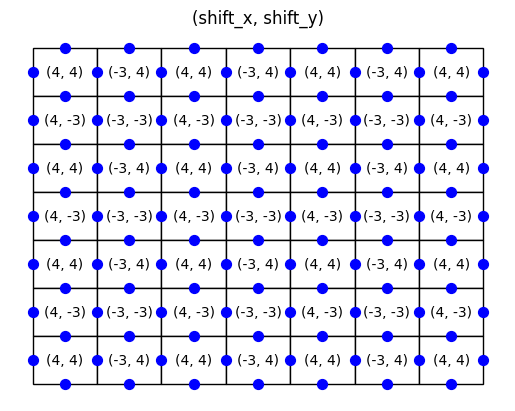

In [26]:
#array of A,B and the x and y shifts
Lx = 7; Ly = 7; #this is the max that can be done. 
#this is the plaquette values
array_shifts = np.empty((Lx, Ly,2))
for ix in range(Lx):
    for iy in range(Ly):        
        array_shifts[ix, iy] = [4 - (ix%2)*7,4 - (iy%2)*7]

print_array_shifts = [[str(tuple([int(s) for s in array_shifts[i,j]])) for i in range(Ly)] for j in range(Lx)]
print_array_shifts = np.array(print_array_shifts)

#####
#plotting the A/B sublattice structure
#####
ybond_qubit = np.ones((Lx, Ly+1))
xbond_qubit = np.ones((Lx+1, Ly))

fig, ax = subplots()
ax.set_axis_off()
for (row_idx, col_idx), cell_val in np.ndenumerate(ybond_qubit):
    ax.scatter([0.5 + row_idx], [col_idx], s=50, color = 'blue')

for (row_idx, col_idx), cell_val in np.ndenumerate(xbond_qubit):
    ax.scatter([row_idx], [0.5+ col_idx], s=50, color = 'blue')


cell_colors=("white", "black")
font_colors=("black", "white")
delta = 1/11/2
tb = Table(ax, bbox = [delta, delta, 1 - 2*delta, 1-2*delta])
n_rows, n_cols = print_array_shifts.shape
width, height = 1.0/(n_rows + 1) , 1.0/(n_cols + 1)
for (row_idx, col_idx), cell_val in np.ndenumerate(print_array_shifts):
    idx = (col_idx + row_idx) % 2
    text_in = str(cell_val)
    tb.add_cell(
        row_idx,
        col_idx,
        width,
        height,
        text=text_in,
        loc="center",
        facecolor=cell_colors[0],
    )
    tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[0])

ax.add_table(tb)
plt.title("(shift_x, shift_y)")


Then, a small test cell for obtaining the starting numbers (top left corner) of any cell at a given translation vector

In [27]:
translation_vector = [2,3] #
base_tuple = np.array([320, 32])
cell_shifts_unit = np.array([0,4])
cell_shifts = []
for i in range(4):
    cell_shifts.append(cell_shifts_unit + i*np.ones(2, dtype = np.int8))
cell_shifts = np.array(cell_shifts).flatten()

starting_tuple = base_tuple + np.array([32*translation_vector[1] + cell_shifts[translation_vector[0]], 32*translation_vector[0] + cell_shifts[translation_vector[1]]])
print(starting_tuple)

[417 101]


putting all the single cell work together: now, only specify the first line (translation vector). The code finds then what the starting pair of top_left qubits for that unit cell is. The (A,B) sublattice is found from the array above at that given unit cell (given by translation_vector), and the shifts in the X and Y direction that is needed is also found the same way

missing couplers
{}
missing qubits
{}


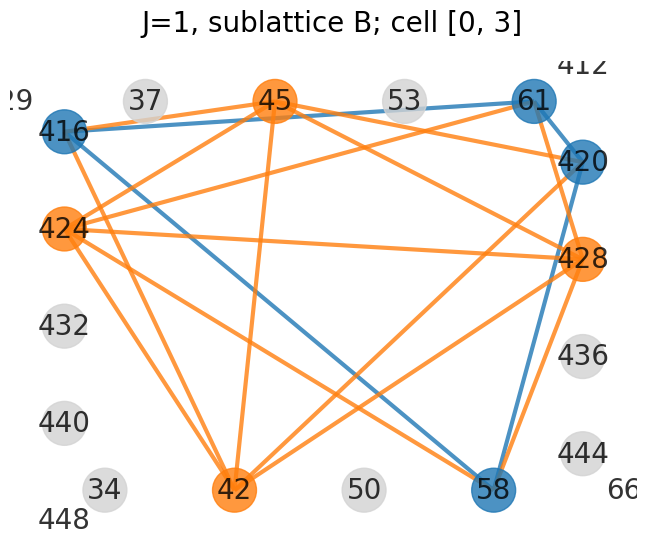

In [28]:
translation_vector = [0,3] #set by hand to check
J_box = 1 #you can decide which parity to encode, with P = -J_box
base_tuple = np.array([320, 32]) #this is the base pair of qubits for cell [0,0]
cell_shifts_unit = np.array([0,4])
cell_shifts = []
for i in range(5):
    cell_shifts.append(cell_shifts_unit + i*np.ones(2, dtype = np.int8))
cell_shifts = np.array(cell_shifts).flatten()

starting_tuple = base_tuple + np.array([32*translation_vector[1] + cell_shifts[translation_vector[0]], 32*translation_vector[0] + cell_shifts[translation_vector[1]]])
#print(starting_tuple)

sublattice = str(array_AB[translation_vector[0], translation_vector[1]])
#print(sublattice)
shift_x = int(array_shifts[translation_vector[0], translation_vector[1], 0])
shift_y = int(array_shifts[translation_vector[0], translation_vector[1], 1])
#print(shift_x, shift_y)
h_dict, J_dict, plaquette, ancillas, missing_coup, missing_qub  = plaquette_embedding(sublattice, -1*J_box, starting_tuple, (shift_x, shift_y))

print("missing couplers")
print(missing_coup)
print("missing qubits")
print(missing_qub)

#these are all the qubits present in this plaquette
all_plot_qubits = []
for p in range(4):
    all_plot_qubits.append(starting_tuple[0] + 8*p)
    all_plot_qubits.append(starting_tuple[0] + 8*p + shift_x)
    all_plot_qubits.append(starting_tuple[1] + 8*p)
    all_plot_qubits.append(starting_tuple[1] + 8*p + shift_y)

all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
edges_draw = [key for key in J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if J_dict[ed] < 0:
        edge_colors.append(all_colors[0])
    elif J_dict[ed] == 1:
        edge_colors.append(all_colors[1])
    elif J_dict[ed] == 2:
        edge_colors.append(all_colors[3])

node_colors = []
for site in all_plot_qubits:
    if site in plaquette:
        node_colors.append(all_colors[1])
    elif site in ancillas:
        node_colors.append(all_colors[0])
    else:
        node_colors.append('#D3D3D3')

G = dnx.zephyr_graph(4)
plt.ion()
plt.axis("off")
plt.title("J={}, sublattice ".format(J_box) + sublattice + "; cell {}".format(translation_vector), x=0.5, y=1.2, fontsize = 20)
#dnx.draw_zephyr(G, nodelist = all_plot_qubits, width = 3, node_size = 1000, quadratic_biases = J_dict, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8)
dnx.draw_zephyr(G, nodelist = all_plot_qubits, width = 3, node_size = 1000, edgelist = edges_draw, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8, edge_color = edge_colors)

# Tiling for a random (or any) $J_{\Box}$ configuration

We now tile the checkerboard lattice with those patterns and create our final embedding. Note that missing qubits and missing couplers are **not** fixed in this complete embedding of $7\times 7$ unit cells, with then $2*7^2 + 2*7 = 63$ sites. In the full $Z_15$ zephyr (we are currently working with the prototype $Z_4$), we would be able to encode $30\times 30 = 900$ unit cells, with a total of $1860$ qubits living on the bonds.

In [29]:
#J grid
#all ones or minus ones
Lx = 7; Ly = 7; #7 is the largest size available
jbox_values = np.ones((Lx,Ly)) #this is an all J_box = 1 experiment - each cell's parity should be -1
#jbox_values = 1 - 2*np.random.randint(0, 2, (Lx, Ly)) #random array of J = +1 or -1
base_tuple = np.array([320, 32])
cell_shifts_unit = np.array([0,4])
#problem_cells = [69, 230]
problem_cells = [69, 230, 33, 226, 227, 160, 224, 70]

cell_shifts = []
for i in range(5):
    cell_shifts.append(cell_shifts_unit + i*np.ones(2, dtype = np.int8))
cell_shifts = np.array(cell_shifts).flatten()

complete_h_dict = {}
complete_J_dict = {}
plaquette_by_plaquette = {}
missing_coup_all = []
missing_qub_all = []
all_plaquettes = []
all_ancillas = []
list_all_missing_qub = []
all_plot_qubits = []

for ix in range(Lx):
    for iy in range(Ly):
        translation_vector = [ix,iy] #
        starting_tuple = base_tuple + np.array([32*translation_vector[1] + cell_shifts[translation_vector[0]], 32*translation_vector[0] + cell_shifts[translation_vector[1]]])
        #print("cell:", starting_tuple)

        J_box = jbox_values[ix,iy]
        sublattice = str(array_AB[translation_vector[0], translation_vector[1]])
        #print(sublattice)
        shift_x = int(array_shifts[translation_vector[0], translation_vector[1], 0])
        shift_y = int(array_shifts[translation_vector[0], translation_vector[1], 1])
        #print(shift_x, shift_y)
        # h_dict, J_dict, plaquette, ancillas, missing_coup, missing_qub  = plaquette_embedding(sublattice, -1*J_box, starting_tuple, (shift_x, shift_y))
        #[69, 230]
        h_dict, J_dict, plaquette, ancillas, missing_coup, missing_qub  = plaquette_embedding_walternate(sublattice, -1*J_box, starting_tuple, (shift_x, shift_y), problem_cells)

        plaquette_by_plaquette.update({tuple(translation_vector):plaquette})
        all_plaquettes.append(plaquette)
        all_ancillas.append(ancillas)
        missing_coup_all.append(missing_coup)
        missing_qub_all.append(missing_qub)
        for node in list(missing_qub):
            list_all_missing_qub.append(node)

        #J_dict is simply updated, it never interferes with itself
        complete_J_dict.update(J_dict)
        #h_dict has to be added to each h if there is doubling
        for key in h_dict.keys():
            if key in complete_h_dict:
                complete_h_dict[key] += h_dict[key]
            else:
                complete_h_dict.update({key:h_dict[key]})

        # print("missing couplers")
        # print(missing_coup)
        # print("missing qubits")
        # print(missing_qub)

        for p in range(4):
            all_plot_qubits.append(starting_tuple[0] + 8*p)
            all_plot_qubits.append(starting_tuple[0] + 8*p + shift_x)
            all_plot_qubits.append(starting_tuple[1] + 8*p)
            all_plot_qubits.append(starting_tuple[1] + 8*p + shift_y)

#massage the missing_coups and missing_qubs lists
dict_missing_coups = {}
for item in missing_coup_all:
    if len(item) > 0:
        dict_missing_coups.update(item)

dict_missing_qubs = {}
for item in missing_qub_all:
    if len(item) > 0:
        for key in item.keys():
            if key in dict_missing_qubs:
                dict_missing_qubs[key] += item[key]
            else:
                dict_missing_qubs.update({key:item[key]})


print("missing couplers")
print(dict_missing_coups)
print("missing qubits")
print(dict_missing_qubs)

missing couplers
{(48, 328): 1, (52, 328): 1, (40, 328): 1, (44, 328): 1, (332, 328): 1, (154, 458): 1, (158, 458): 1, (138, 458): 1, (142, 458): 1, (458, 461): 1, (178, 458): 1, (182, 458): 1, (170, 458): 1, (174, 458): 1, (462, 458): 1, (242, 463): 1, (246, 463): 1, (234, 463): 1, (238, 463): 1, (463, 459): 1}
missing qubits
{328: 0, 458: 0, 463: 0}


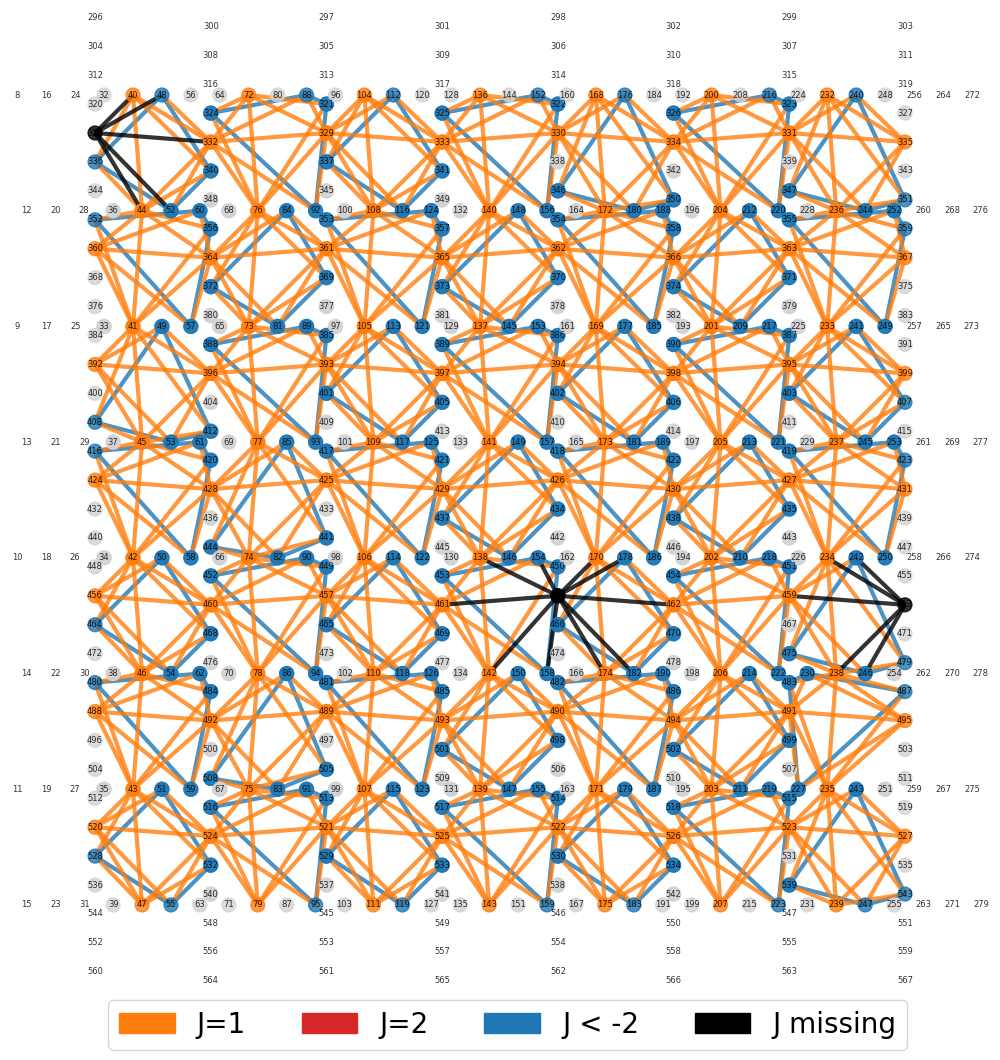

In [30]:
edges_draw = [key for key in complete_J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if complete_J_dict[ed] < 0:
        edge_colors.append(all_colors[0])
    elif complete_J_dict[ed] == 1:
        edge_colors.append(all_colors[1])
    elif complete_J_dict[ed] == 2:
        edge_colors.append(all_colors[3])

for ed in dict_missing_coups.keys():
    edges_draw.append(ed)
    edge_colors.append('#000000')

node_colors = []
all_ancillas = np.array(all_ancillas).flatten()
all_plaquettes = np.array(all_plaquettes).flatten()
list_all_missing_qub = np.array([key for key in dict_missing_qubs.keys()])
for site in all_plot_qubits:
    if site in all_plaquettes:
        color = all_colors[1]
    elif site in all_ancillas:
        color = all_colors[0]
    else:
        color = '#D3D3D3'
    
    if site in list_all_missing_qub:
        color = '#000000'
        
    node_colors.append(color)

G = dnx.zephyr_graph(4)
plt.ion()
fig = plt.figure(figsize=(10,10))
plt.axis("off")
#plt.title("J={}, sublattice ".format(J_box) + sublattice + "; cell {}".format(translation_vector), x=0.5, y=1.2, fontsize = 20)
#dnx.draw_zephyr(G, nodelist = all_plot_qubits, width = 3, node_size = 1000, quadratic_biases = J_dict, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8)
dnx.draw_zephyr(G, nodelist = all_plot_qubits, width = 3, node_size = 100, 
edgelist = edges_draw, with_labels = True, node_color = node_colors, 
font_size = 6, alpha = 0.8, edge_color = edge_colors)

legend_elements = [Patch(facecolor=all_colors[1], edgecolor=all_colors[1],
                         label='J=1'), 
                    Patch(facecolor=all_colors[3], edgecolor=all_colors[3],
                         label='J=2'), 
                    Patch(facecolor=all_colors[0], edgecolor=all_colors[0],
                         label='J < -2'), 
                    Patch(facecolor='#000000', edgecolor='#000000',
                         label='J missing')]

# Create the figure
#fig, ax = plt.subplots()
plt.legend(handles=legend_elements, bbox_to_anchor=(0.1, -0.01), loc='upper left', borderaxespad=0, ncol=4, fontsize = 20)
plt.show()

In [31]:
#run it
run_true_or_false = True
if run_true_or_false:
    num_reads = 200
    response = sampler.sample_ising(h = complete_h_dict, J=complete_J_dict,
                                                num_reads=num_reads,
                                                annealing_time=100,
                                                answer_mode="raw")

    #dwave.inspector.show(response)

In [32]:
dwave.inspector.show(response)

Serving Inspector on http://127.0.0.1:18000/?problemId=a035c1e0-4659-4a9e-ac9c-0256a01e31b8

'http://127.0.0.1:18000/?problemId=a035c1e0-4659-4a9e-ac9c-0256a01e31b8'

extract the list of plaquettes and the indices in the variables of the response that the qubits correspond to

In [33]:
plaq_variable_index = []
for i in range(int(len(all_plaquettes)/4)):
    qubit_indices = all_plaquettes[4*i:(4*i+4)]
    single_plaquette = []
    for k in range(4):
        where_is_it = np.where(np.array(response.variables) == qubit_indices[k])[0]
        if len(where_is_it) > 0:
            single_plaquette.append(where_is_it[0])
    plaq_variable_index.append(np.array(single_plaquette))
print(plaq_variable_index)

[array([  0, 163,   4]), array([  4, 187,   1, 183]), array([  1, 207,   5, 203]), array([  5, 231,   2, 227]), array([  2, 250,   6, 247]), array([  6, 273,   3, 269]), array([  3, 293,   7, 289]), array([ 22, 160,  26, 163]), array([ 26, 184,  23, 187]), array([ 23, 204,  27, 207]), array([ 27, 228,  24, 231]), array([ 24, 248,  28, 250]), array([ 28, 270,  25, 273]), array([ 25, 290,  29, 293]), array([ 44, 164,  48, 160]), array([ 48, 188,  45, 184]), array([ 45, 208,  49, 204]), array([ 49, 232,  46, 228]), array([ 46, 251,  50, 248]), array([ 50, 274,  47, 270]), array([ 47, 294,  51, 290]), array([ 66, 161,  70, 164]), array([ 70, 185,  67, 188]), array([ 67, 205,  71, 208]), array([ 71, 229,  68, 232]), array([ 68,  72, 251]), array([ 72, 271,  69, 274]), array([ 69, 291,  73, 294]), array([ 88, 165,  92, 161]), array([ 92, 189,  89, 185]), array([ 89, 209,  93, 205]), array([ 93, 233,  90, 229]), array([ 90, 252,  94]), array([ 94, 275,  91, 271]), array([ 91, 295,  95, 291]),

In [34]:
values = []
values_min = []
#find minimum energy
min_ene = response.record[0][1]
count = 0

for resp in response.record:
    current_value = 0
    for k in range(len(plaq_variable_index)):
        current_value += np.prod(resp[0][plaq_variable_index[k]])
    values.append(current_value)
    if resp[1] == min_ene:
        count += 1
        values_min.append(current_value)

print("number of samples in lowest energy state: ", count/len(response.record))
print("avg value of Sum(P)/N for the lowest energy states: ", np.mean(values_min)/(7*7))
print("avg value of Sum(P)/N for all states: ", np.mean(values)/(7*7))

number of samples in lowest energy state:  0.895
avg value of Sum(P)/N for the lowest energy states:  -0.9062820658989853
avg value of Sum(P)/N for all states:  -0.9


### Doing a real space average for each plaquette

In [35]:
#unit cells in the same order as the plaq_variable_index
unit_cell_after = [key for key in list(plaquette_by_plaquette)]
all_avg = np.zeros((Lx,Ly))
min_ene = response.record[0][1]
count = 0
for resp in response.record:
    #if resp[1] == min_ene:
        count += 1
        for k in range(len(plaq_variable_index)):
            all_avg[unit_cell_after[k]] += np.prod(resp[0][plaq_variable_index[k]])
            current_value += np.prod(resp[0][plaq_variable_index[k]])

/tmp/ipykernel_490/3411243910.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')


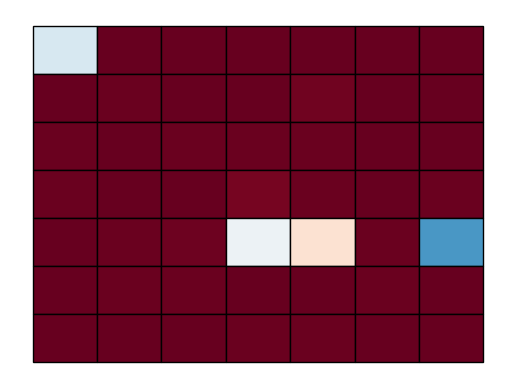

In [36]:
cmap = cm.get_cmap('RdBu')
#norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)

#this is the plaquette values
ary = np.transpose(all_avg/count)
#random_colors = np.random.randint(0, 2, (Lx, Ly))
#this is the individual qubit values (at nodes)
# node_values = np.random.randint(0, 2, (Lx+1, Ly+1))

# ybond_qubit = np.random.randint(0, 2, (Lx, Ly+1))
# xbond_qubit = np.random.randint(0, 2, (Lx+1, Ly))

cell_colors=("white", "black")
font_colors=("black", "white")
node_colors = ("red", "blue")
fmt="%.2f"
figsize=None
fontsize=None
show_text = False

fig, ax = subplots(figsize=figsize)
ax.set_axis_off()
delta = 1/11/2
tb = Table(ax, bbox = [delta, delta, 1 - 2*delta, 1-2*delta])

n_rows, n_cols = ary.shape
width, height = 1.0/(n_rows + 1) , 1.0/(n_cols + 1)
for (row_idx, col_idx), cell_val in np.ndenumerate(ary):
    idx = (col_idx + row_idx) % 2
    color_code = int(cell_val > 0.5)
    # if show_text:
    #     text_in = fmt % cell_val
    # else:
    #     text_in = ""
    tb.add_cell(
        row_idx,
        col_idx,
        width,
        height,
        #text=text_in,
        loc="center",
        facecolor=cmap((cell_val + 1)/2),
    )
    #print(cmap(cell_val))
    #tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[color_code])

tb.set_fontsize(fontsize)
ax.add_table(tb)


make colorbar

/tmp/ipykernel_490/2996533790.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')
/tmp/ipykernel_490/2996533790.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


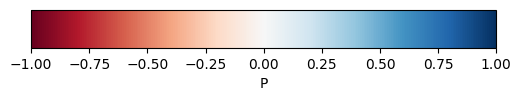

In [37]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = cm.get_cmap('RdBu')
norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('P')
fig.show()

# Fixing the embedding: qubits

Most crucial is fixing the missing qubits. These can be found by visual observation, and are replaced by 2 or 3-chains (K = -2) on all.

**One major distinction is that the missing qubits are sometimes ancillas, sometimes they are sites. Sites can be changed to a chain (2 or 3 chain), while missing ancillas can be fixed by simply going to a different representation of the gadget. These missing ancillas are fixed directly in the embedding function.**

It also seems that plaquettes with only a missing coupler can be fixed with an alternate embedding. *This is now done in a new embedding function!*

In [38]:
#J grid
#all ones or minus ones
Lx = 7; Ly = 7; #7 is the largest size available
jbox_values = -np.ones((Lx,Ly)) #this is an all J_box = 1 experiment - each cell's parity should be -1
#jbox_values = 1 - 2*np.random.randint(0, 2, (Lx, Ly)) #random array of J = +1 or -1
base_tuple = np.array([320, 32])
cell_shifts_unit = np.array([0,4])
#problem_cells = [69, 230]
problem_cells = [69, 230, 33, 226, 227, 160, 224, 70]
#this could be done automatically by identifying the "cells" that have missing couplers.

cell_shifts = []
for i in range(5):
    cell_shifts.append(cell_shifts_unit + i*np.ones(2, dtype = np.int8))
cell_shifts = np.array(cell_shifts).flatten()

complete_h_dict = {}
complete_J_dict = {}
plaquette_by_plaquette = {}
missing_coup_all = []
missing_qub_all = []
all_plaquettes = []
all_ancillas = []
list_all_missing_qub = []
all_plot_qubits = []

for ix in range(Lx):
    for iy in range(Ly):
        translation_vector = [ix,iy] #
        starting_tuple = base_tuple + np.array([32*translation_vector[1] + cell_shifts[translation_vector[0]], 32*translation_vector[0] + cell_shifts[translation_vector[1]]])
        #print("cell:", starting_tuple)

        J_box = jbox_values[ix,iy]
        sublattice = str(array_AB[translation_vector[0], translation_vector[1]])
        #print(sublattice)
        shift_x = int(array_shifts[translation_vector[0], translation_vector[1], 0])
        shift_y = int(array_shifts[translation_vector[0], translation_vector[1], 1])
        #print(shift_x, shift_y)
        # h_dict, J_dict, plaquette, ancillas, missing_coup, missing_qub  = plaquette_embedding(sublattice, -1*J_box, starting_tuple, (shift_x, shift_y))
        #[69, 230]
        h_dict, J_dict, plaquette, ancillas, missing_coup, missing_qub  = plaquette_embedding_walternate(sublattice, -1*J_box, starting_tuple, (shift_x, shift_y), problem_cells)

        plaquette_by_plaquette.update({tuple(translation_vector):plaquette})
        all_plaquettes.append(plaquette)
        all_ancillas.append(ancillas)
        missing_coup_all.append(missing_coup)
        missing_qub_all.append(missing_qub)
        for node in list(missing_qub):
            list_all_missing_qub.append(node)

        #J_dict is simply updated, it never interferes with itself
        complete_J_dict.update(J_dict)
        #h_dict has to be added to each h if there is doubling
        for key in h_dict.keys():
            if key in complete_h_dict:
                complete_h_dict[key] += h_dict[key]
            else:
                complete_h_dict.update({key:h_dict[key]})

        # print("missing couplers")
        # print(missing_coup)
        # print("missing qubits")
        # print(missing_qub)

        for p in range(4):
            all_plot_qubits.append(starting_tuple[0] + 8*p)
            all_plot_qubits.append(starting_tuple[0] + 8*p + shift_x)
            all_plot_qubits.append(starting_tuple[1] + 8*p)
            all_plot_qubits.append(starting_tuple[1] + 8*p + shift_y)

#massage the missing_coups and missing_qubs lists
dict_missing_coups = {}
for item in missing_coup_all:
    if len(item) > 0:
        dict_missing_coups.update(item)

dict_missing_qubs = {}
for item in missing_qub_all:
    if len(item) > 0:
        for key in item.keys():
            if key in dict_missing_qubs:
                dict_missing_qubs[key] += item[key]
            else:
                dict_missing_qubs.update({key:item[key]})


print("missing couplers")
print(dict_missing_coups)
print("missing qubits")
print(dict_missing_qubs)

missing couplers
{(52, 328): 2, (332, 328): 1, (328, 48): 1, (158, 458): 2, (154, 458): 1, (458, 461): 1, (182, 458): 2, (462, 458): 1, (458, 178): 1, (246, 463): 2, (242, 463): 1, (463, 459): 1}
missing qubits
{328: -1, 458: -2, 463: -1}


In [39]:
# #Qubit replacement dict:
# qubit_replacements = {}
# qubit_replacements.update({328:[344,32]}) #qubit
# qubit_replacements.update({458:[134,474,166]}) #qubit
# qubit_replacements.update({463:[455,226]}) #qubit

#Qubit replacement dict:
qubit_replacements = {}
qubit_replacements.update({328:[344,32]}) #qubit
qubit_replacements.update({458:[477,478]}) #qubit
qubit_replacements.update({461:[461,134]}) #change qubit
qubit_replacements.update({462:[462,166]}) #change qubit
qubit_replacements.update({463:[455,226]}) #qubit


fixed_qubits = [key for key in qubit_replacements.keys()]


**Note**: It is better to fix the missing bulk site with three 2-chains rather than a single 3-chain, that way we can use anneal offsets to render the transverse field effects isotropic on the lattice. For example:

458 is replaced to [134,166] - they couple through vertical or horizontal long couplers.

461 becomes a 2-chain: [461,134]

462 becomes a 2-chain: [462,166]

Chains to add to the coupler dictionary

In [40]:
#create chains
adding_chains = {}
#2 chains have a -4 constraint, 
for chain in qubit_replacements.values():
    #K = -len(chain)
    K = -2
    for i in range(len(chain) - 1):
        edge = (chain[i], chain[i+1])
        if edge in sampler.edgelist:
            adding_chains.update({edge:K})
        elif Reverse(edge) in sampler.edgelist:
            adding_chains.update({Reverse(edge):K})
        else:
            print("problem with ", edge)
print(adding_chains)

{(32, 344): -2, (477, 478): -2, (134, 461): -2, (166, 462): -2, (226, 455): -2}


New h dictionary to add to it

In [41]:
new_h_values = {}
for key in fixed_qubits:
    if key in complete_h_dict:
        #print(complete_h_dict[ind])
        h_value = complete_h_dict[key]
    else:
        #print(dict_missing_qubs[ind])
        h_value = dict_missing_qubs[key]
    chain_sites = qubit_replacements[key]
    Nchain = len(chain_sites)
    for site in chain_sites:
        new_h_values.update({site:h_value/Nchain})

print(new_h_values)

{344: -0.5, 32: -0.5, 477: -1.0, 478: -1.0, 461: -1.0, 134: -1.0, 462: -1.0, 166: -1.0, 455: -0.5, 226: -0.5}


add new couplers for the chains to replace the missing couplers (note that ancillas have already been fixed)

In [42]:
adding_new_couplers = {}
unfixed_couplers = {}
for coup in dict_missing_coups.keys():
    value = dict_missing_coups[coup]
    #print(coup)
    if coup[0] in qubit_replacements:
        listA = qubit_replacements[coup[0]]
        #print(listA)
    else:
        listA = [coup[0]]
    if coup[1] in qubit_replacements:
        listB = qubit_replacements[coup[1]]
    else:
        listB = [coup[1]]
    #print(listA)
    chain_sites = [(listA), (listB)]

    #create list of possible edges
    possible_edges = list(itertools.product(listA, listB))
    new_bonds = np.zeros(len(possible_edges))
    #print(possible_edges)
    count = 0
    for edge in possible_edges:
        if edge in sampler.edgelist:
            adding_new_couplers.update({edge:value})
            new_bonds[count] = 1
        elif Reverse(edge) in sampler.edgelist:
            adding_new_couplers.update({Reverse(edge):value})
            new_bonds[count] = 1
        count +=1

    if sum(new_bonds) == 0.0 :
        #print(coup)
        unfixed_couplers.update({coup:value})
#    print(new_bonds)

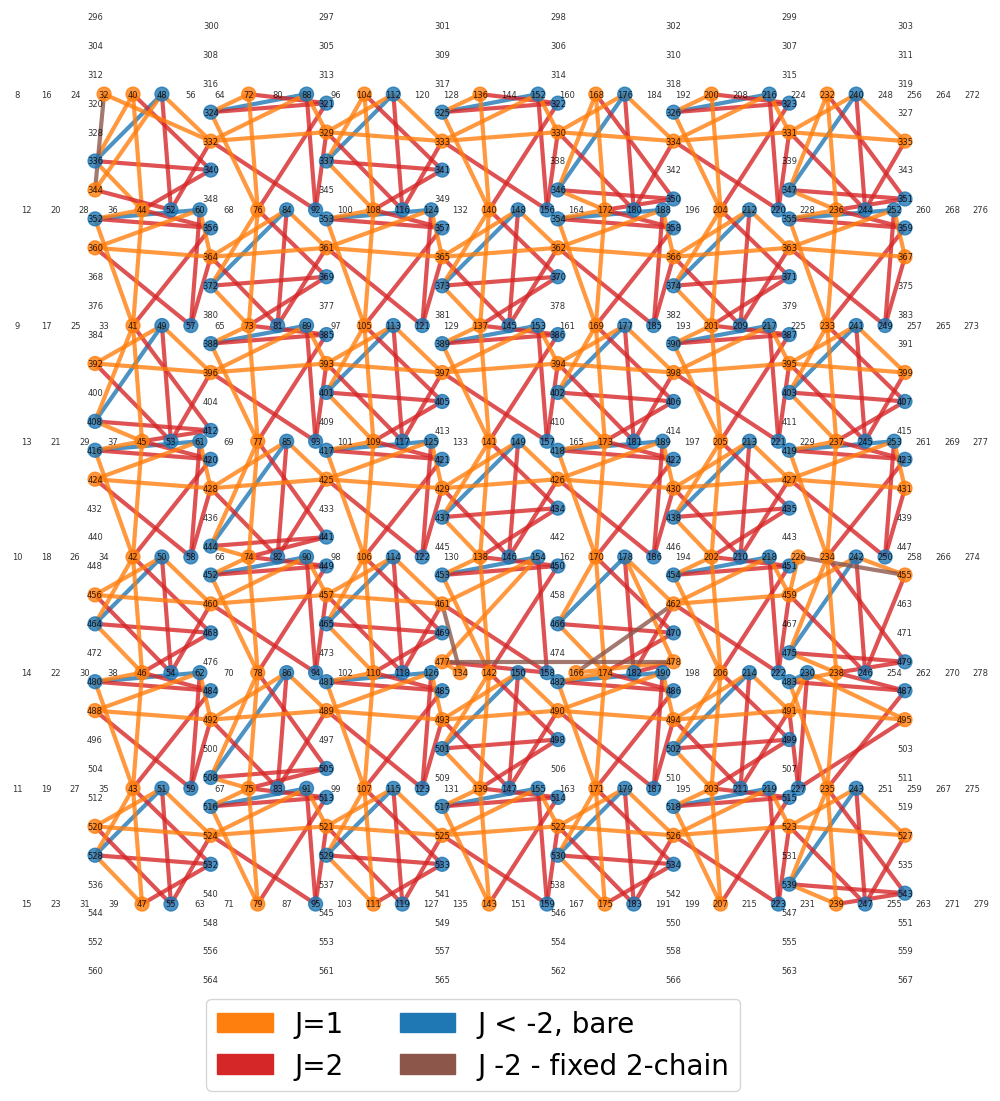

In [43]:
new_fixed_J_dict = complete_J_dict
new_fixed_J_dict.update(adding_new_couplers)
new_fixed_J_dict.update(adding_chains)

new_fixed_h_dict = complete_h_dict
new_fixed_h_dict.update(new_h_values)

edges_draw = [key for key in new_fixed_J_dict.keys()]
all_ancillas = np.array(all_ancillas).flatten()
edge_colors = []
for ed in edges_draw:
    if new_fixed_J_dict[ed] < 0:
        if ed[0] in all_ancillas:
            edge_colors.append(all_colors[0])
        else:
            edge_colors.append(all_colors[5])
    elif new_fixed_J_dict[ed] == 1:
        edge_colors.append(all_colors[1])
    elif new_fixed_J_dict[ed] == 2:
        edge_colors.append(all_colors[3])

for ed in unfixed_couplers.keys():
    edges_draw.append(ed)
    edge_colors.append('#000000')

node_colors = []
all_plot_qubits = [key for key in new_fixed_h_dict.keys()]

for site in all_plot_qubits:
    color = all_colors[1]
    if site in all_ancillas:
        color = all_colors[0]
    
    # if site in list_all_missing_qub:
    #     color = '#000000'
        
    node_colors.append(color)

G = dnx.zephyr_graph(4)
plt.ion()
fig = plt.figure(figsize=(10,10))
plt.axis("off")
#plt.title("J={}, sublattice ".format(J_box) + sublattice + "; cell {}".format(translation_vector), x=0.5, y=1.2, fontsize = 20)
#dnx.draw_zephyr(G, nodelist = all_plot_qubits, width = 3, node_size = 1000, quadratic_biases = J_dict, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8)
dnx.draw_zephyr(G, nodelist = all_plot_qubits, width = 3, node_size = 100, 
edgelist = edges_draw, with_labels = True, node_color = node_colors, 
font_size = 6, alpha = 0.8, edge_color = edge_colors)

legend_elements = [Patch(facecolor=all_colors[1], edgecolor=all_colors[1],
                         label='J=1'), 
                    Patch(facecolor=all_colors[3], edgecolor=all_colors[3],
                         label='J=2'), 
                    Patch(facecolor=all_colors[0], edgecolor=all_colors[0],
                         label='J < -2, bare'), 
                    Patch(facecolor=all_colors[5], edgecolor=all_colors[5],
                         label='J -2 - fixed 2-chain'), ]

# Create the figure
#fig, ax = plt.subplots()
plt.legend(handles=legend_elements, bbox_to_anchor=(0.2, -0.01), loc='upper left', borderaxespad=0, ncol=2, fontsize = 20)
plt.show()

Changing the bare J does not seem to change anything.

In [44]:
inv_temp = 1
J_mod_dict = {}
for key in new_fixed_J_dict.keys():
    J_mod_dict.update({key:new_fixed_J_dict[key]*inv_temp})
h_mod_dict = {}
for key in new_fixed_h_dict.keys():
    h_mod_dict.update({key:new_fixed_h_dict[key]*inv_temp})

#run it
run_true_or_false = True
if run_true_or_false:
    num_reads = 200
    response = sampler.sample_ising(h = h_mod_dict, J=J_mod_dict,
                                                num_reads=num_reads,
                                                annealing_time=10,
                                                answer_mode="raw")



In [45]:
# dwave.inspector.show(response)

In [46]:
avg_ene = 0
for resp in response.record:
    avg_ene += resp[1]

#energy per plaquette
#offset by the number of 2 chains
print((avg_ene/len(response.record) )/(7*7)) 

-12.001224489795916


The definition of a new plaquette measurement based on the majority rule for the chains.

In [47]:
#new plaquettes
plaq_variable_index_mod = []
all_plaquettes = np.array(all_plaquettes).flatten()
all_plaquettes_mod = all_plaquettes
for i in range(len(all_plaquettes)):
    if all_plaquettes[i] in qubit_replacements:
        all_plaquettes_mod[i] = qubit_replacements[all_plaquettes[i]][0]

single_qubits_mag = np.unique(all_plaquettes_mod)

#does not work yet, only works after a run has been done and an embedding is defined.
for i in range(int(len(all_plaquettes_mod)/4)):
    qubit_indices = all_plaquettes_mod[4*i:(4*i+4)]
    single_plaquette = []
    for k in range(4):
        where_is_it = np.where(np.array(response.variables) == qubit_indices[k])[0]
        if len(where_is_it) > 0:
            single_plaquette.append(where_is_it[0])
    if len(single_plaquette) != 4:
        print("woops")
    plaq_variable_index_mod.append(np.array(single_plaquette))
#print(plaq_variable_index_mod)

indices_for_mag = []
for i in range(len(single_qubits_mag)):
    where_is_it = np.where(np.array(response.variables) == single_qubits_mag[i])[0]
    if len(where_is_it) > 0:
        indices_for_mag.append(where_is_it[0])

#unit cells in the same order as the plaq_variable_index
unit_cell_after = [key for key in list(plaquette_by_plaquette)]
all_avg = np.zeros((Lx,Ly))
all_avg_min = np.zeros((Lx,Ly))
#min_ene = response.record[0][1]
min_ene = np.min([response.record[i][1] for i in range(len(response.record))])
count = 0
mag_av = 0
mag_av_2 = 0
for resp in response.record:
    if resp[1] == min_ene:
        count += 1
        for k in range(len(plaq_variable_index_mod)):
            all_avg_min[unit_cell_after[k]] += np.prod(resp[0][plaq_variable_index_mod[k]])
    for k in range(len(plaq_variable_index_mod)):
        all_avg[unit_cell_after[k]] += np.prod(resp[0][plaq_variable_index_mod[k]])

    for i in range(len(indices_for_mag)):
        mag_av += np.sum(resp[0][indices_for_mag[i]])
        mag_av_2 += np.sum(resp[0][indices_for_mag[i]]**2)

print("percentage of samples in lowest energy state: ", 100*count/len(response.record))
print("avg value of Sum(P)/N for the lowest energy states: ", np.sum(all_avg_min/count)/(7*7))
print("avg value of Sum(P)/N for all states: ", np.sum(all_avg/len(response.record))/(7*7))
print("avg magnetization for all states: ", mag_av/len(response.record)/(7*7*4))

percentage of samples in lowest energy state:  3.5
avg value of Sum(P)/N for the lowest energy states:  0.9591836734693877
avg value of Sum(P)/N for all states:  0.8079591836734694
avg magnetization for all states:  0.02790816326530612


/tmp/ipykernel_490/1323171146.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')


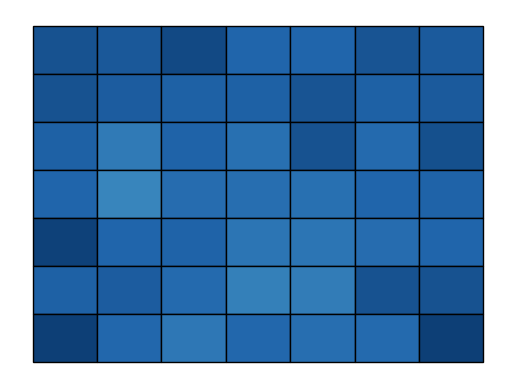

In [48]:
cmap = cm.get_cmap('RdBu')
#norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)

#this is the plaquette values
ary = np.transpose(all_avg/len(response.record)) #plot over all obtained states
# ary = np.transpose(all_avg_min/count) #plot over only the lowest energy states
cell_colors=("white", "black")
font_colors=("black", "white")
node_colors = ("red", "blue")
fmt="%.2f"
figsize=None
fontsize=None
show_text = False

fig, ax = subplots(figsize=figsize)
ax.set_axis_off()
delta = 1/11/2
tb = Table(ax, bbox = [delta, delta, 1 - 2*delta, 1-2*delta])

n_rows, n_cols = ary.shape
width, height = 1.0/(n_rows + 1) , 1.0/(n_cols + 1)
for (row_idx, col_idx), cell_val in np.ndenumerate(ary):
    idx = (col_idx + row_idx) % 2
    color_code = int(cell_val > 0.5)
    # if show_text:
    #     text_in = fmt % cell_val
    # else:
    #     text_in = ""
    tb.add_cell(
        row_idx,
        col_idx,
        width,
        height,
        #text=text_in,
        loc="center",
        facecolor=cmap((cell_val + 1)/2),
    )
    #print(cmap(cell_val))
    #tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[color_code])

tb.set_fontsize(fontsize)
ax.add_table(tb)


/tmp/ipykernel_490/2996533790.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')
/tmp/ipykernel_490/2996533790.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


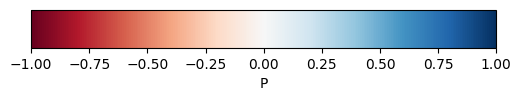

In [49]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = cm.get_cmap('RdBu')
norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('P')
fig.show()

### current 2-chains, and anneal offsets for those

In [50]:
adding_chains

{(32, 344): -2, (477, 478): -2, (134, 461): -2, (166, 462): -2, (226, 455): -2}

the biggest question here is whether the ancilla chains also need to perceive the transverse field in the same way. My intuition is that they do not need to, but truly, the 4-chains will freeze earlier leading to some plaquettes's parity value freezing out earlier or lower.

### Changing the "temperature"

Here, one needs to change the bare J values - but which ones? To be tested. Perhaps it is the overall energy scale that needs to be tuned down.

# Things to help you plot - colors!

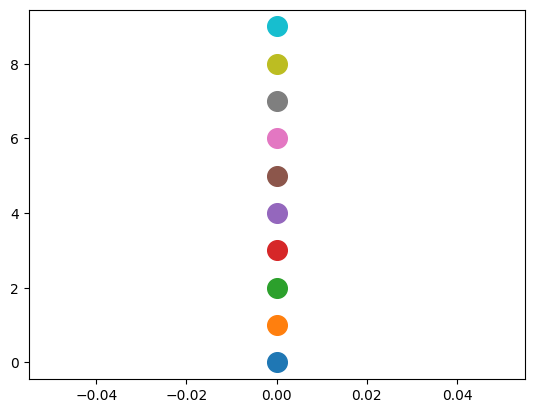

In [51]:
all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

count = 0
for i in range(len(all_colors)):
    plt.scatter([0], [count], color = all_colors[i], s=200)
    count += 1
